In [223]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

Using TensorFlow backend.
/Users/mollyliebeskind/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mollyliebeskind/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mollyliebeskind/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint1

# Load Data

In [13]:
model_df = pd.read_csv('../data/model_df.csv')

# Train Test Split

In [108]:
def tts(data):
    data = data.drop(['sales','date'],axis=1)
    train, test = data[0:-12].values, data[-12:].values
    
    return train, test

train, test = tts(model_df)

In [109]:
train.shape

(35, 13)

In [110]:
test.shape

(12, 13)

In [129]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [136]:
y_train.shape

(35,)

# Modeling Functions

In [251]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [235]:
def predict_df(unscaled_predictions):
    
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('../data/train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result, original_df

In [265]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, label='Original')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, label='Predicted')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    
    plt.savefig(f'../model_output/{model_name}_forecast.png')

In [262]:
model_scores = {}

def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    
    model_scores[model_name] = [rmse, mae, r2]
    
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df, original_df = predict_df(unscaled)
    plot_results(unscaled_df, original_df, model_name)

# Linear Regression

RMSE: 0.07958021240371228
MAE: 0.06099616733341725
R2 Score: 0.9806758070651099


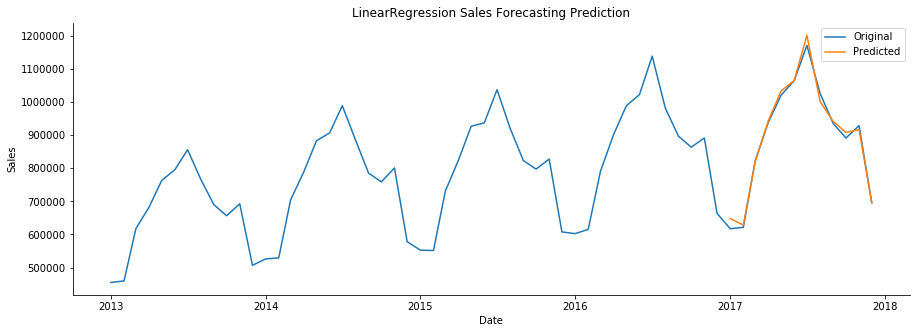

In [266]:
run_model(train, test, LinearRegression(), 'LinearRegression')

# Random Forest Regressor

RMSE: 0.08868559404899433
MAE: 0.07435571821395197
R2 Score: 0.976000768455735


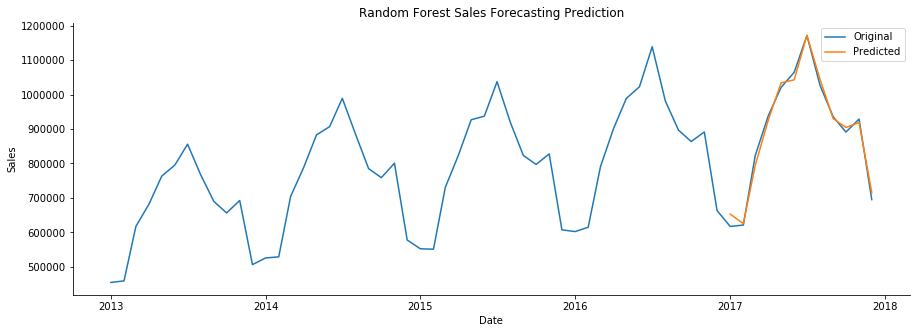

In [267]:
run_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 'Random Forest')

# XGBoost

RMSE: 0.06659651302647451
MAE: 0.057151808072476724
R2 Score: 0.9864669976441471


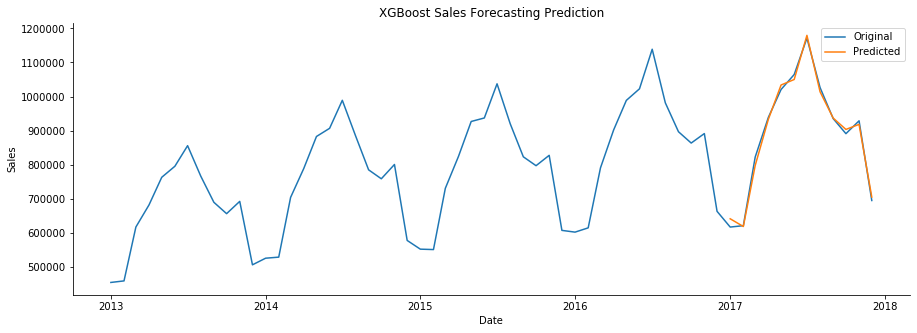

In [268]:
run_model(train, test, XGBRegressor( n_estimators=100, 
                                    learning_rate=0.2, 
                                    objective='reg:squarederror'), 'XGBoost')

# LSTM

In [289]:
def lstm_model(train_data, test_data):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    
    model_scores['lstm'] = [rmse, mae, r2]
    
    X_test = X_test
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df, original_df = predict_df(unscaled)
    plot_results(unscaled_df, original_df, 'lstm')

Epoch 1/200
35/35 [==============================] - 1s 30ms/step - loss: 0.3680
Epoch 2/200
35/35 [==============================] - 0s 3ms/step - loss: 0.3108
Epoch 3/200
35/35 [==============================] - 0s 3ms/step - loss: 0.2888
Epoch 4/200
35/35 [==============================] - 0s 3ms/step - loss: 0.2703
Epoch 5/200
35/35 [==============================] - 0s 3ms/step - loss: 0.2540
Epoch 6/200
35/35 [==============================] - 0s 4ms/step - loss: 0.2392
Epoch 7/200
35/35 [==============================] - 0s 4ms/step - loss: 0.2253
Epoch 8/200
35/35 [==============================] - 0s 3ms/step - loss: 0.2120
Epoch 9/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1990
Epoch 10/200
35/35 [==============================] - 0s 4ms/step - loss: 0.1862
Epoch 11/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1737
Epoch 12/200
35/35 [==============================] - 0s 3ms/step - loss: 0.1616
Epoch 13/200
35/35 [================

35/35 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 103/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 104/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 105/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 106/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 107/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 108/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 109/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 110/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 111/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 112/200
35/35 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 113/200
35/35 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 114/200
35/35 [=========

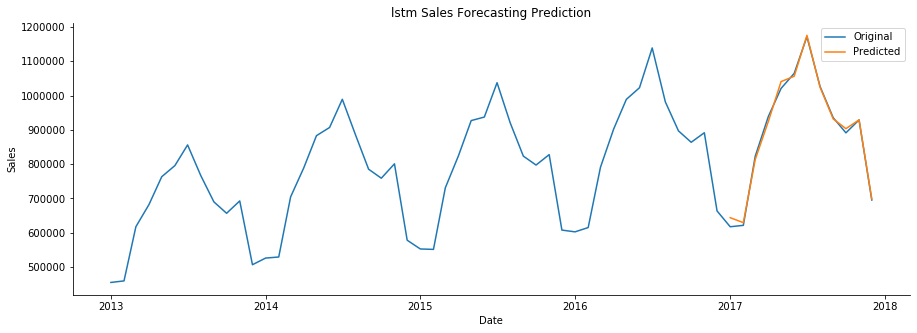

In [290]:
lstm_model(train, test)